dataset : https://www.kaggle.com/c/street-view-getting-started-with-julia

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from skimage import io
from skimage import color
from skimage import feature
from skimage import transform

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

%matplotlib inline

Using TensorFlow backend.


In [2]:
#labels csv
labels_ = [] # first line is dirty
with open('./trainLabels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels_.append(row[1])


In [3]:
#loading the dataset
images = []
labels = []
SAMPLE_DIR = './trainResized'
for i, label in enumerate(labels_):
    if i == 0 : continue
    labels.append(label)
    im = io.imread('{}/{}.Bmp'.format(SAMPLE_DIR, i))
    gray = color.rgb2gray(im)
    ############edges = feature.canny(gray)
    images.append(gray)

images = np.array(images)
labels = np.array(labels)

print (images.shape, labels.shape)

(6283, 20, 20) (6283,)


# This is the original after loading initial transforms

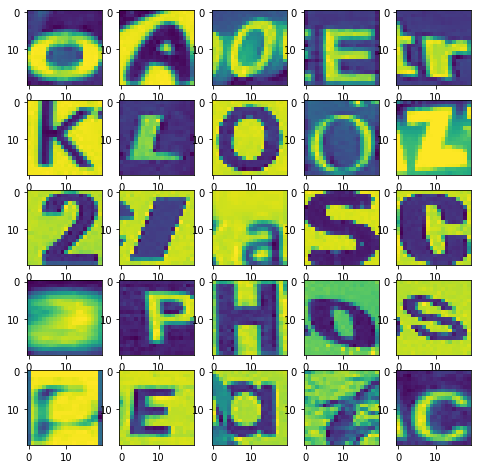

In [4]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images[random.randint(0, len(images)-1)])

In [5]:
# filtering the set
# this is optional!
"""
letters = ['A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'X', 'Y', 
           '1', '2','3', '4', '5', '6', '7', '8', '9', '0',
          'a', 'b', 'c', 'd', 'e', 'f']
          """


#letters = ['A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'X', 'Y']
letters = list(set(labels))

mask = (labels == letters[0])
for i in range(len(letters)-1):
    mask = mask | (labels == letters[i+1])

images = images[mask]
labels = labels[mask]
print (images.shape, labels.shape)



(6283, 20, 20) (6283,)


In [6]:
# splitting for training ant testing
images_train, images_test, labels_train, labels_test = model_selection.train_test_split(images, labels, test_size=0.33, random_state=45)
print (images_train.shape, images_test.shape, labels_train.shape, labels_test.shape)



(4209, 20, 20) (2074, 20, 20) (4209,) (2074,)


# In these 2 steps we are normalizing the set to have equal number of samples for all cathegory -- also generating new smaples

In [7]:
#label stats
def label_stats(labels, letters):
    stats = {}
    for letter in letters:
        stats[letter] = len(labels[labels == letter])
    return stats

print (label_stats(labels, letters))
print (label_stats(labels_train, letters))
print (images_train.shape, labels_train.shape)

{'1': 65, 'r': 123, 'h': 45, 'd': 54, 'N': 279, 'k': 26, 'x': 23, 'j': 20, 'C': 170, 't': 107, '4': 37, 'W': 57, 'S': 270, 'J': 52, 'l': 74, 'a': 156, 'I': 270, 'Y': 54, '7': 31, 'E': 357, 'v': 23, '2': 59, 'b': 25, 'g': 32, 'i': 128, 'X': 43, 'A': 459, 'q': 28, 'P': 131, 'U': 83, 'p': 37, 'D': 165, 'n': 125, 'f': 28, '0': 78, 'L': 168, 'm': 44, 'u': 39, '9': 36, '5': 41, 'K': 67, 'H': 152, 's': 95, 'O': 291, 'Z': 31, '6': 42, 'F': 69, 'M': 127, 'R': 309, 'B': 90, 'z': 20, 'o': 129, 'e': 196, 'Q': 21, 'c': 52, '8': 21, 'T': 257, 'V': 64, 'y': 37, 'w': 24, '3': 36, 'G': 111}
{'1': 42, 'r': 80, 'h': 33, 'd': 40, 'N': 196, 'k': 14, 'x': 14, 'j': 13, 'C': 120, 't': 73, '4': 25, 'W': 37, 'S': 173, 'J': 35, 'l': 38, 'a': 108, 'I': 179, 'Y': 43, '7': 19, 'E': 237, 'v': 17, '2': 40, 'b': 17, 'g': 21, 'i': 89, 'X': 33, 'A': 307, 'q': 19, 'P': 82, 'U': 56, 'p': 23, 'D': 118, 'n': 85, 'f': 18, '0': 54, 'L': 110, 'm': 30, 'u': 29, '9': 20, '5': 22, 'K': 45, 'H': 106, 's': 60, 'O': 201, 'Z': 16, '6

In [8]:
# generates more images the way that every sample has equal number
def generate_and_eq_more_images(images, labels, letters):
    
    im_list = images.tolist()
    labels_list = labels.tolist()
    
    stats = label_stats(labels, letters)
    max_sample_size = max(stats.values()) # the maximus sample size
    print ("Max: ", max_sample_size )
    for letter in letters:
        samples_to_gen = max_sample_size - stats[letter] # number of new samples to be generated
        sample_images = images[labels == letter] # original image sample, this is the source for the generated images
        print("label ", letter, samples_to_gen)
        for i in range(samples_to_gen): #adding generated images N times
            random_im = sample_images[random.randint(0,len(sample_images)-1)]
            im_list.append(gen_transform(random_im))
            labels_list.append(letter)
            
    return np.array(im_list), np.array(labels_list)
    
def gen_transform(im):
    new_im = transform.rotate(im, random.randint(-20, 20))
    return new_im
    
    
    
images_train, labels_train = generate_and_eq_more_images(images_train, labels_train, letters)

print (images_train.shape, labels_train.shape)
print (label_stats(labels_train, letters))

Max:  307
label  r 227
label  d 267
label  N 111
label  U 251
label  k 293
label  0 253
label  x 293
label  j 294
label  C 187
label  2 267
label  t 234
label  W 270
label  I 128
label  S 134
label  v 290
label  J 272
label  a 199
label  1 265
label  Y 264
label  E 70
label  O 106
label  7 288
label  L 197
label  H 201
label  A 0
label  X 274
label  q 288
label  o 216
label  P 225
label  D 189
label  h 274
label  n 222
label  l 269
label  f 289
label  e 177
label  i 218
label  b 290
label  u 278
label  5 285
label  9 287
label  K 262
label  m 277
label  p 284
label  s 247
label  c 277
label  Z 291
label  6 283
label  F 255
label  M 214
label  R 107
label  3 280
label  g 286
label  B 245
label  z 295
label  Q 296
label  8 295
label  4 282
label  T 140
label  V 264
label  y 281
label  w 292
label  G 230
(19034, 20, 20) (19034,)
{'1': 307, 'r': 307, 'h': 307, 'd': 307, 'N': 307, 'k': 307, 'x': 307, 'j': 307, 'C': 307, 't': 307, '4': 307, 'W': 307, 'S': 307, 'J': 307, 'l': 307, 'a': 307, '

In [9]:
## the canny transform
# the preprocess function
def preprocess_images(img_list):
    im_list = []
    for i in range(len(img_list)):
        im_list.append(feature.canny(img_list[i]))
    return np.array(im_list)

images_train = preprocess_images(images_train)

T


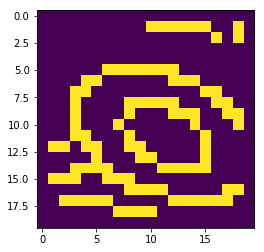

In [11]:
N = 119
print(labels[N])
i = images_train[N]

plt.imshow(i)



# This is what the machine sees -- after canny transform

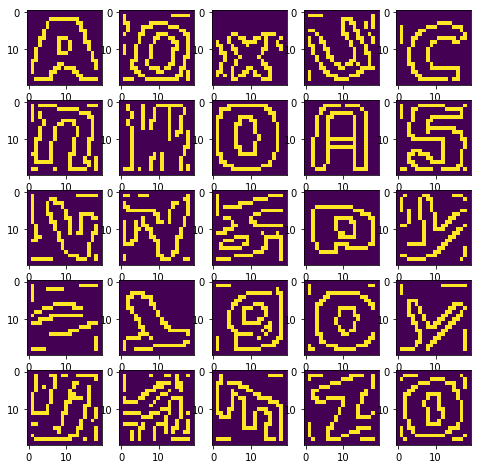

In [144]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images_train[random.randint(0, len(images_train)-1)])

# The Random forest way

In [145]:
x_train = images_train.reshape(images_train.shape[0], -1)
x_test = preprocess_images(images_test)
x_test = x_test.reshape(x_test.shape[0], -1)

y_train = labels_train
y_test = labels_test

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(19034, 400) (2074, 400) (19034,) (2074,)


In [146]:
#clf = svm.SVC()
clf = ensemble.RandomForestClassifier()

clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.99784595986130087

In [147]:
pred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print (score)

0.202989392478


[[ 3  2  3 ...,  0  0  1]
 [ 0  3  0 ...,  0  0  0]
 [ 1  0  5 ...,  0  1  0]
 ..., 
 [ 1  2  1 ...,  2  0  0]
 [ 0  2  1 ...,  0  4  1]
 [ 0  1  1 ...,  0  1 16]]


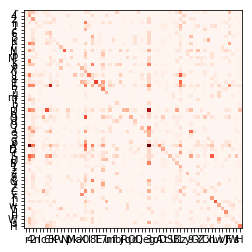

In [148]:
cm = metrics.confusion_matrix(y_test, pred, labels=letters)
print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)

# The neural network way


In [149]:
# binarizing the labels
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
yy_train = lb.transform(labels_train)
yy_test = lb.transform(labels_test)

xx_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], -1)
xx_test = preprocess_images(images_test)
xx_test = xx_test.reshape(xx_test.shape[0], xx_test.shape[1], xx_test.shape[2], -1)
print (xx_train.shape, xx_test.shape, yy_train.shape, yy_test.shape)



(19034, 20, 20, 1) (2074, 20, 20, 1) (19034, 62) (2074, 62)


In [170]:
model = Sequential()
B = 2

model.add(Convolution2D(32, B, B, input_shape = (xx_train.shape[1], xx_train.shape[2], 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
print (model.output)

model.add(Convolution2D(64, B, B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
print (model.output)

model.add(Flatten())
print (model.output)

model.add(Dense(4 * 4 * 64))
print (model.output)


model.add(Dense(1024))
print (model.output)

model.add(Dense(512))
print (model.output)

model.add(Dense(512))
print (model.output)




model.add(Dense(yy_train.shape[1]))
print (model.output)


Tensor("Relu_17:0", shape=(?, 9, 9, 32), dtype=float32)
Tensor("Relu_18:0", shape=(?, 4, 4, 64), dtype=float32)
Tensor("Reshape_27:0", shape=(?, ?), dtype=float32)
Tensor("add_319:0", shape=(?, 1024), dtype=float32)
Tensor("add_320:0", shape=(?, 1024), dtype=float32)
Tensor("add_321:0", shape=(?, 512), dtype=float32)
Tensor("add_322:0", shape=(?, 512), dtype=float32)
Tensor("add_323:0", shape=(?, 62), dtype=float32)


In [171]:
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [186]:
E = 20
history = model.fit(xx_train, yy_train, nb_epoch=E, batch_size=500)

Epoch 1/20
19034/19034 [==============================] - 11s - loss: 0.0116 - acc: 0.7649    
Epoch 2/20
19034/19034 [==============================] - 11s - loss: 0.0116 - acc: 0.7635    
Epoch 3/20
19034/19034 [==============================] - 10s - loss: 0.0115 - acc: 0.7609    
Epoch 4/20
19034/19034 [==============================] - 10s - loss: 0.0115 - acc: 0.7683    
Epoch 5/20
19034/19034 [==============================] - 10s - loss: 0.0115 - acc: 0.7662    
Epoch 6/20
19034/19034 [==============================] - 11s - loss: 0.0115 - acc: 0.7705    
Epoch 7/20
19034/19034 [==============================] - 10s - loss: 0.0115 - acc: 0.7690    
Epoch 8/20
19034/19034 [==============================] - 10s - loss: 0.0115 - acc: 0.7729    
Epoch 9/20
19034/19034 [==============================] - 11s - loss: 0.0114 - acc: 0.7683    
Epoch 10/20
19034/19034 [==============================] - 10s - loss: 0.0114 - acc: 0.7702    
Epoch 11/20
19034/19034 [========================

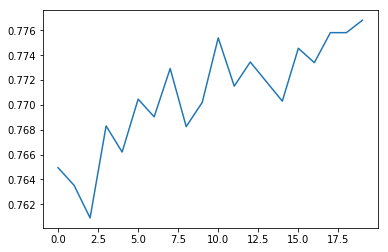

In [187]:
plt.plot(history.history['acc'])

0.593539054966


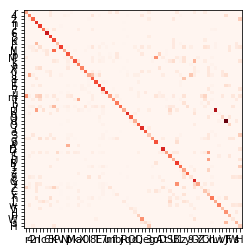

In [188]:
pred = np.argmax(model.predict(xx_test), axis=1)
truth = np.argmax(yy_test, axis=1)

print(metrics.accuracy_score(truth, pred))

cm = metrics.confusion_matrix(truth, pred)
#print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)


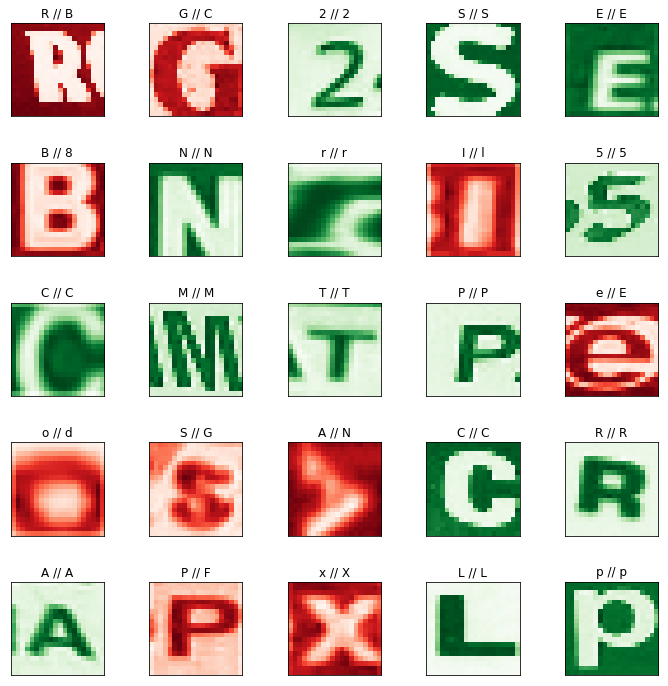

In [189]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace = 0.5)

N = 5
for i in range(N * N):
    plt.subplot(N,N, i+1)
    R = random.randint(0, images_test.shape[0]-1)
    img = images_test[R]
    label = labels_test[R]
    
    pred = model.predict(preprocess_images([img]).reshape(1, 20, 20, -1))
    label_pred = lb.inverse_transform(pred)[0]
    cmap = 'Greens'
    if label != label_pred : cmap = 'Reds'
    plt.imshow(img, cmap = cmap)
    plt.xticks([])
    plt.yticks([])    
    plt.title(label + ' // ' + label_pred )

In [97]:
model.save('my_model1.h5')